In [11]:
# !pip install --upgrade xarray matplotlib numpy netcdf4 h5netcdf seaborn pingouin

In [28]:
import xarray as xr
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

Code for downloading dataset

In [2]:
from pathlib import Path
import requests

def download_from_sciebo(public_url, to_filename, is_file=True):
    """
    Downloads a file or folder from a shared URL on Sciebo.
    """
    # Create the folder if a longer path was described
    path = Path(to_filename)
    if len(path.parts) > 1:
        Path(to_filename).parent.mkdir(parents=True, exist_ok=True)

    r = requests.get(public_url + "/download", stream=True)

    if 'Content-Length' in r.headers and is_file:
        total_size = int(r.headers['Content-Length'])

    with open(to_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

download_from_sciebo('https://uni-bonn.sciebo.de/s/JFeueaaWCTVhTZh', 'data/steinmetz_2016-12-14_Cori.nc')

Load dataset

In [31]:
dset = xr.load_dataset(f"./data/steinmetz_2016-12-14_Cori.nc")
dset

<xarray.Dataset> Size: 118MB
Dimensions:             (trial: 364, time: 250, cell: 734,
                         waveform_component: 3, sample: 82, probe: 384,
                         brain_area_lfp: 7, spike_id: 2446173)
Coordinates:
  * trial               (trial) int32 1kB 1 2 3 4 5 6 ... 360 361 362 363 364
  * time                (time) float64 2kB 0.01 0.02 0.03 0.04 ... 2.48 2.49 2.5
  * cell                (cell) int32 3kB 1 2 3 4 5 6 ... 729 730 731 732 733 734
  * waveform_component  (waveform_component) int32 12B 1 2 3
  * probe               (probe) int32 2kB 1 2 3 4 5 6 ... 380 381 382 383 384
  * brain_area_lfp      (brain_area_lfp) <U4 112B 'ACA' 'LS' ... 'SUB' 'VISp'
  * spike_id            (spike_id) int32 10MB 1 2 3 ... 2446171 2446172 2446173
Dimensions without coordinates: sample
Data variables: (12/31)
    contrast_left       (trial) int8 364B 100 0 100 0 50 0 ... 50 50 0 25 100
    contrast_right      (trial) int8 364B 0 50 50 0 100 0 ... 100 25 25 50 0 100
    gocue               (trial) float64 3kB 1.027 0.8744 0.8252 ... nan nan nan
    stim_onset          (trial) float64 3kB 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    feedback_type       (trial) float64 3kB 1.0 1.0 1.0 1.0 ... nan nan nan nan
    feedback_time       (trial) float64 3kB 1.187 1.438 0.986 ... nan nan nan
    ...                  ...
    waveform_w          (cell, sample, waveform_component) float32 722kB 0.0 ...
    waveform_u          (cell, waveform_component, probe) float32 3MB 0.0 ......
    lfp                 (brain_area_lfp, trial, time) float64 5MB -2.851 ... ...
    spike_time          (spike_id) float32 10MB 0.2676 2.308 ... 2.189 2.399
    spike_cell          (spike_id) uint32 10MB 1 1 1 1 1 ... 734 734 734 734 734
    spike_trial         (spike_id) uint32 10MB 21 21 31 37 ... 364 364 364 364
Attributes:
    session_date:  2016-12-14
    mouse:         Cori
    stim_onset:    0.5
    bin_size:      0.01

In [5]:
variables_for_analysis = ['pupil_x', 'pupil_y', 'contrast_left', 'contrast_right', 'wheel', 'response_type', 'active_trials']
df = dset[variables_for_analysis].to_dataframe().reset_index()
active_trials = df['active_trials']
df = df[active_trials]

Regression analysis

In [22]:
def regression_plot(df, trial_num):
    df_trial = df[df['trial'] == 37]
    return sns.regplot(data=df_trial, x='pupil_x', y='wheel')
    
def regression_analysis(df, trial_num):
    df_trial = df[df['trial'] == 37]
    return pg.corr(df_trial['pupil_x'], df_trial['wheel'])

In [23]:
regression_analysis(df, 37)

,n,r,CI95%,p-val,BF10,power
pearson,250,0.021498,"[-0.1, 0.15]",0.73517,0.084,0.063161


,n,r,CI95%,p-val,BF10,power
pearson,250,0.021498,"[-0.1, 0.15]",0.73517,0.084,0.063161


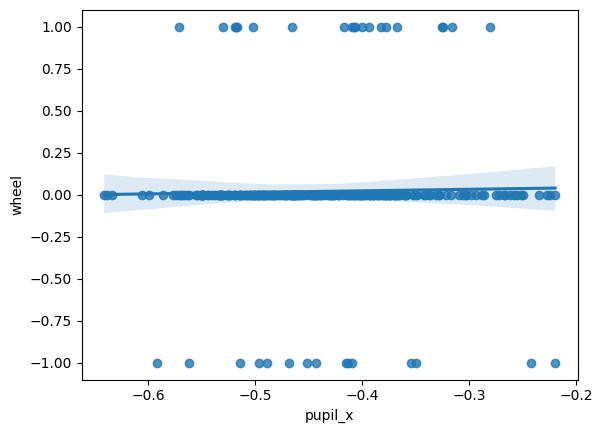

In [13]:
df_37 = df[df['trial']==37]
sns.regplot(data=df_37, x='pupil_x', y='wheel')
pg.corr(df_37['pupil_x'], df_37['wheel'])

In [27]:
df[df['spike_trial'] == 1]['spike_cell'].nunique()
df[df['spike_trial'] == 10]['spike_cell'].nunique()
df[df['spike_trial'] == 24]['spike_cell'].nunique()

508

In [33]:
def count_cells_spiked_in_trial(df, trial_num):
    return df[df['spike_trial'] == trial_num]['spike_cell'].nunique()


In [34]:
count_cells_spiked_in_trial(df, 24)

508